# Evaluating the quality of dimensionality reduction methods

---

### _Zichen Wang, PhD_
### _Maayan Lab_
### _Icahn School of Medicine at Mount Sinai_
### _New York, NY_ 
### <i>BD2K-LINCS summer seminar 2019</i>
### _July 2, 2019_
---

# 1. Introduction

## 1.1. The bigger picture: Where does dimensionality reduction fit in the world of AI/ML/DL?


![NVDA AI-ML](https://blogs.nvidia.com/wp-content/uploads/2016/07/Deep_Learning_Icons_R5_PNG.jpg.png)


Machine Learning:
- Supervised Learning
    + Classification
    + Regression
- Unsupervised Learning
    + Dimensionality reduction
    + Clustering
    + Outlier detection
- Reinformcement Learning

![](https://cdn-images-1.medium.com/max/1600/0*sQmcKODThlssh2V5.png)
slide from Yann LeCun

# 2. Dimensionality reduction (DR)
    
+ **Motivation**    
    Many real-world datasets are high-dimensional, that is, having many features, for example: static images, videos, natural language text, biological/biomedial data such as gene expression or electronic medical records. 
    Reducing the dimensionality of this data is useful for:
    - **Visualization**: Reducing the dimensionality from $m$ dimensions to 2 or 3 dimensions can help plot the data points, thus enabling humans to see the data.
    - **Modeling and Machine Learning**: Reducing the dimensionality from $m$ to $d$ dimensions where $d << m$. The dataset may fit in a much lower-dimension without losing much information. The low-dimension representation of the data is easier to analyze.
    

+ **Defination/Formulation**    
    We have $n \times m$ data matrix $\mathbf{X}$ consisting of $n$ data vectors $\mathbf{x_i} (i ∈ {1, 2,. .. ,n})$ with dimensionality $m$. The goal of DR is to map $\mathbf{X}$ to a $n \times d$ matrix $\mathbf{X'}$ where $d << m$.


+ **Types of DR Approaches:**
    - **Linear**: principal component analysis (PCA), singular value decomposition (SVD), Random Projection
    - **[Non-linear](https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction)**
        + **Parametric**: Learn a function that maps data from a high-dimentional space to a low-dimentional space: [Autoencoder](https://en.wikipedia.org/wiki/Autoencoder)    
        + **Distance-based embedding**: Preserve the distances between the data points in high-dimensional space. Many of these methods involve the use of a **graph** to represent the distances between objects. 
            - Example algorithms: [t-distributed stochastic neighbor embedding (t-SNE)](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), Spectral Embedding, Multi-dimensional scaling (MDS). 
            - Non-parametric methods: cannot fit new data points in high-dimensional space into the embedding space.


## 2.1. Linear DR
+ **Principal Components Analysis (PCA)**
    Find linearly uncorrelated orthogonal axes (principal components, PC) in the $m$ dimensional space to project the data points onto those PCs. The first several PCs capture the largest variance in the data.
    ![](https://i.stack.imgur.com/lNHqt.gif)    
    The PCs can be determined via eigen-decomposition of the covariance matrix of $\mathbf{X}$:
    $$ \mathbf{C} = \frac{\mathbf{X^\top} \mathbf{X}}{m-1} = \mathbf{V} \mathbf{\Lambda} \mathbf{V^\top} $$    
    , where $\mathbf{V}$ is a matrix of eigenvectors (PCs) and $\mathbf{\Lambda}$ is a diagonal matrix of eigenvalues.
    
+ **Singular Value Decomposition (SVD)**    
    For a real matrix $\mathbf{X}$:
    $$ \mathbf{X} = \mathbf{U}\mathbf{\Sigma}\mathbf{V^\top}  $$

    <img src="img/SVD_illustration.png" width="300px" />

    For truncated SVD, only the $d$ column vectors of $\mathbf{U}$, $d$ row vectors of $\mathbf{V^\top}$ corresponding to the $d$ largest singular values $\mathbf{\Sigma_d}$ are calculated: 
    $$ \mathbf{X_d} = \mathbf{U_d}\mathbf{\Sigma_d}\mathbf{V_d^\top}  $$
    
    SVD is closely related to PCA: 
    $$ \mathbf{C} = \mathbf{V \Sigma U^\top U \Sigma V^\top} /(m-1) = \mathbf{V} \frac{\mathbf{\Sigma^2}}{m-1} \mathbf{V^\top} $$    


+ **Random Projection (RP)**
    A simple and computationally efficient way to reduce the dimensionality of the data by trading a controlled amount of accuracy to preserve the pairwise distances between any two samples of the dataset:     
    $\mathbf{X^{RP}} = \mathbf{X}\mathbf{R} $    
    , where $\mathbf{R}$ is a $m \times d$ random matrix with elements drawn from $\mathcal{N}(0, 1/d)$    
    RP is based on [Johnson–Lindenstrauss lemma](https://en.wikipedia.org/wiki/Johnson%E2%80%93Lindenstrauss_lemma), which states that any high dimensional dataset can be randomly projected into a lower dimensional Euclidean space while controlling the distortion in the pairwise distances: there exists a set of points of size $n$ that needs dimension $ \frac{log(n)}{\epsilon^2} $ in order to preserve the distances between all pair of points.
    
+ **PCA and RP for DR in practice using the Iris dataset**

In [1]:
from __future__ import division, print_function
import os, sys, json
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from scipy.spatial import distance as dist
import networkx as nx
from sklearn import preprocessing, manifold, decomposition, random_projection, neighbors, metrics
from sklearn.model_selection import cross_val_score

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')
from IPython import display
np.random.seed(2018)
tf.set_random_seed(2018)

from utils import *

In [2]:
# Load Iris dataset
iris = sns.load_dataset('iris')
print (iris.shape)
iris.head()

(150, 5)


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


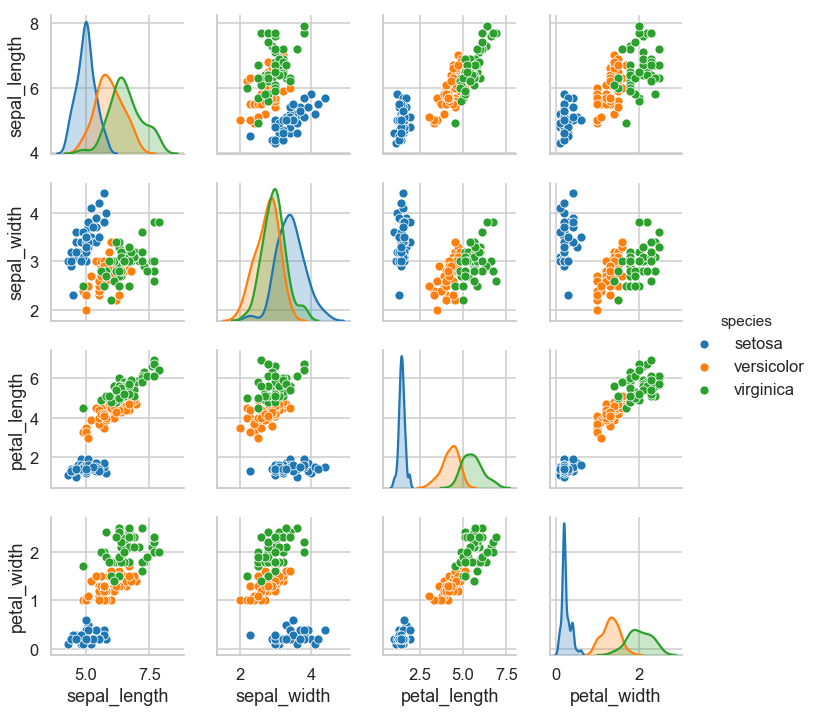

In [3]:
sns.pairplot(iris, hue="species");

In [4]:
X = iris.drop('species', axis=1).values
print (X.shape)

(150, 4)


In [5]:
# Perform PCA on the X
pca = decomposition.PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

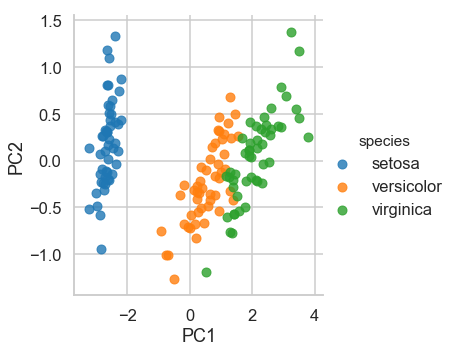

In [6]:
iris_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
iris_pca['species'] = iris['species']
# Plot the Iris data in the first two PCs
sns.lmplot(x="PC1", y="PC2", data=iris_pca, fit_reg=False, hue='species', legend=True);

In [7]:
rp = random_projection.GaussianRandomProjection(n_components=2, random_state=2018)
X_rp = rp.fit_transform(X)

In [8]:
# The random matrix R
rp.components_

array([[-0.19570424,  0.41143079,  1.51914769, -0.90473394],
       [ 0.35516339,  0.60530412, -0.10096783,  0.07783737]])

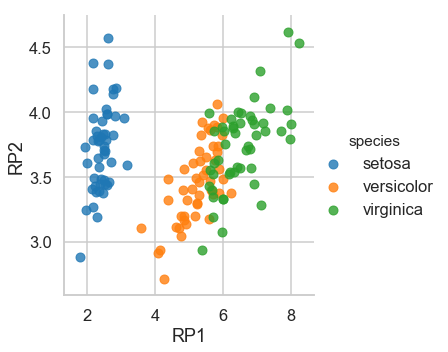

In [9]:
iris_rp = pd.DataFrame(X_rp, columns=['RP1', 'RP2'])
iris_rp['species'] = iris['species']
# Plot the Iris data in the first two PCs
sns.lmplot(x="RP1", y="RP2", data=iris_rp, fit_reg=False, hue='species', legend=True)

In [10]:
# Examine how well the pairwise distances are preserved by PCA and RP
d = dist.pdist(X, 'euclidean')
d_pca = dist.pdist(X_pca, 'euclidean')
d_rp = dist.pdist(X_rp, 'euclidean')

D = np.array([d, d_pca, d_rp]).T
D = pd.DataFrame(D, columns=['original', 'PCA', 'RP'])
D.corr()

,original,PCA,RP
original,1.000000,0.998384,0.977802
PCA,0.998384,1.000000,0.977998
RP,0.977802,0.977998,1.000000


## 2.2. Non-linear DR

+ **Distance-based Embedding**: Preserves the distances between data points in high-dimensional space. Many of these methods involve the use of a **graph** to represent the distances between objects. 
    - Example algorithms: [t-distributed stochastic neighbor embedding (t-SNE)](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), Spectral Embedding. 
    - Non-parametric methods: cannot fit new data points in high-dimensional space into the embedding space.
        
+ **Parametric**: Learn a function that maps the data from a high-dimentional space to a low-dimentional space: [Autoencoder](https://en.wikipedia.org/wiki/Autoencoder)    

### 2.2.1. Graph Theory and Graph-based DR

#### 2.2.1.1. Basic Concepts of a Graph
+ $G(V, E)$: a set of vertices/nodes $V$ connected by a set of edges $E$. Edges in the graph can be directed or undirected.
![Undirected graph](https://upload.wikimedia.org/wikipedia/commons/thumb/5/5b/6n-graf.svg/500px-6n-graf.svg.png)

+ **Important concepts:**
    - **Connected components**: subgraphs in which any two nodes in the subgraph are connected to each other by a path, and which these nodes are not connected to additional nodes in the supergraph.
    ![connected components](https://upload.wikimedia.org/wikipedia/commons/thumb/8/85/Pseudoforest.svg/540px-Pseudoforest.svg.png)
    - **Degree**: number of edges for a given node
    - **Degree distribution**: probability distribution of degree of nodes.    
    Example of a power-law degree distribution which is commonly observed in real world biological and other networks:
    ![power-law degree distribution](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a8/Barabasi-albert_model_degree_distribution.svg/731px-Barabasi-albert_model_degree_distribution.svg.png)
    Random network and scale-free network:
    ![](https://upload.wikimedia.org/wikipedia/commons/thumb/7/77/Scale-free_network_sample.png/800px-Scale-free_network_sample.png)
    - **Adjacency matrix**: $$
    \mathbf{A} = [A_{ij}] = 
    \begin{cases}
      0, & \text{if node i, j are not connected}\  \\
      w_{ij}, & \text{otherwise}
    \end{cases}
    $$
    - **Laplacian matrix**: $$
    \mathbf{L} = \mathbf{D} - \mathbf{A}
    $$
+ Network layout algorithms:
    - **Force-based Layout**: repulsive forces between all pairs of nodes, attractive forces applied on the edges. https://bl.ocks.org/mbostock/4062045

#### 2.2.1.2. Graph-based DR

**Workflow:**

0. Starts with $\mathbf{X}$ ($n \times m$)     
0. Compute pairwise distance/similarity matrix -> $\mathbf{A}$ ($n \times n$)    
0. Construct a graph $G$ to represent the local and global geometric/topological structure of the data    
0. Project $G$ into low-dimensional space.    


**Algorithms:**

- **Spectral Embedding**: also known as Laplacian Eigenmaps. Performs PCA on the Laplacian matrix.
- **t-SNE**: t-distributed stochastic neighbor embedding. 
    0. Converts pairwise distances between data points to a probability distribution such that closer data points have higher probability of staying closer
    0. Makes a similar probability distribution in the low-dimentional space and minimizes the [KL divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between the two distributions.

- **Fireworks Layout**: uses a force-based layout algorithm (edge-repulsive strong clustering) to project the similarity graph into 2D or 3D space. This has been used to visualize [gene expression signatures](http://amp.pharm.mssm.edu/L1000FWD/), and [patients in EMR](http://amp.pharm.mssm.edu/emr-net1/). 
    How to to convert $\mathbf{A}$ to $G$?
    + k-Nearest Neighbor (kNN) graph: how to choose k?
    + Thresholding: how to choose a threshold?

**Step-by-step graph-based DR using the Iris dataset**

[neighbors.kneighbors_graph](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.kneighbors_graph.html): first compute a pairwise distance matrix $\mathbf{D}$, then connect each node with its $k$ nearest neighbors based on $\mathbf{D}$ then return a adjacency matrix representing this graph.

In [11]:
# Compute the adjacency matrix from the data using kNN
k = 5
adj_mat = neighbors.kneighbors_graph(X, k, 
                                     mode='connectivity', 
                                     metric='euclidean',
                                     include_self=True
                                    )
print (adj_mat.toarray()[:5, :5])

# Construct a networkx.Graph object from the adjacency matrix
G = nx.from_scipy_sparse_matrix(adj_mat)
print ('Number of nodes:', G.number_of_nodes())
print ('Number of edges:', G.number_of_edges())

[[1. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 1. 0.]
 [0. 0. 1. 1. 0.]
 [1. 0. 0. 0. 1.]]
Number of nodes: 150
Number of edges: 562


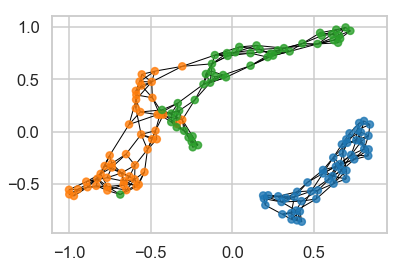

In [12]:
# Run network layout algorithm for the graph 
pos = nx.spring_layout(G, iterations=50)

# Plot the resultant network layout
unique_species = iris.species.unique().tolist()
nx.draw_networkx_nodes(G, pos=pos, 
                       node_color=[COLORS10[unique_species.index(s)] for s in iris.species], 
                       node_size=50,
                       alpha=0.8
                      )
nx.draw_networkx_edges(G, pos=pos)
plt.show()

### 2.2.2. Parametric Methods for Non-Linear DR

+ **Parametric**: Learns a function that maps data from a high-dimentional space to a low-dimentional space: [Autoencoder](https://en.wikipedia.org/wiki/Autoencoder)    

    - **Autoencoder** is an Artificial Neuron Network that aims to learn a useful representation (code) of the original data as well as: 1) An encoding function to map the original data to the code, and 2) A decoding function to map the code to the original data.
    
    <a title="By Chervinskii (Own work) [CC BY-SA 4.0 (http://creativecommons.org/licenses/by-sa/4.0)], via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File%3AAutoencoder_structure.png"><img width="512" alt="Autoencoder structure" src="https://upload.wikimedia.org/wikipedia/commons/2/28/Autoencoder_structure.png"/></a>
    
    Encoding function:    
    $$\phi(\mathbf{x}) = \sigma(\mathbf{Wx} + \mathbf{b}) = \mathbf{z}$$

    Decoding function:    
    $$\psi(\mathbf{y}) = \sigma(\mathbf{W^{\top}z} + \mathbf{b'}) = \mathbf{x'}$$

    Objective/Loss function:
    $$L(\mathbf{x}, \mathbf{x'}) = ||\mathbf{x} - \mathbf{x'}||^2 $$

    , where $\mathbf{x}$ is input data represented as a vector of features, $\mathbf{z}$ is the code vector constructed by encoding function, $\sigma$ is a [non-linear activation function](https://www.tensorflow.org/versions/r0.9/api_docs/python/nn.html#activation-functions), $\mathbf{W}, \mathbf{W^\top}$ are weight matrices, $\mathbf{b}, \mathbf{b'}$ are bias vectors.


## 5. Experiments with the MNIST Dataset of Hand Written Digits

- MNIST: 28x28 pixel images in grey scale of handwritten digits
- Evaluate different DR algorithms by
    0. Visual inspection of the data
    0. Generalization errors: calculate the generalization errors of 1-nearest neighbor classifiers that are trained on the low-dimensional data representation. As is done in [van der Maaten et al. Dimensionality Reduction: A Comparative Review](https://www.tilburguniversity.edu/upload/59afb3b8-21a5-4c78-8eb3-6510597382db_TR2009005.pdf).
        - Intuition: do the nearest pairs of points belong to the same class?


Retrieve the MNIST data and sample a subset to experiment with.

In [13]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [14]:
print (mnist.train.num_examples)
print (mnist.test.num_examples)

55000
10000


In [15]:
X_train, X_test = min_max_scale(mnist.train.images, mnist.test.images)
print (X_train.shape, X_test.shape)
labels_train = mnist.train.labels
n_samples = int(mnist.train.num_examples)
print (labels_train.shape)

(55000, 784) (10000, 784)
(55000,)


In [16]:
# Take a smaller sample of the the data for shorter execution time
N = 2000 # number of samples
sample_idx = np.random.choice(n_samples, N, replace=False)
X = X_train[sample_idx]
labels = labels_train[sample_idx]
print (X.shape, labels.shape)

(2000, 784) (2000,)


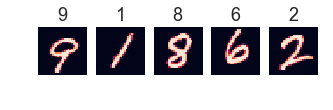

In [17]:
fig, axes = plt.subplots(1,5, figsize=(5, 1))
for i in range(5):
    ax = axes[i]
    ax.imshow(X[i].reshape(28, 28))
    ax.set_axis_off()
    ax.set_title(labels[i])

## Evaluation of DR 
Evaluate using the generalization errors of 1-nearest neighbor classifiers that are trained on the low-dimensional data representation. As is done in [van der Maaten et al. Dimensionality Reduction: A Comparative Review](https://www.tilburguniversity.edu/upload/59afb3b8-21a5-4c78-8eb3-6510597382db_TR2009005.pdf)


#### Intuition of this method:
Data points with the same class label should be closer to each other in the low dimension space. Therefore, when looking for the nearest neighbor for a given data point, one should more likely find data points with the same class label. 

In [18]:
# Split data points into 80% training and 20% testing
def NN_generalization_error(X, labels):
    '''Train 1-NN classifier on the training set of the low-dim data,
    and evaluate on the test set to get the error (1-accuracy).
    '''
    clf = neighbors.KNeighborsClassifier(n_neighbors=1)
    # 5-fold cross-validation averaged accuracy
    avg_accuracy = cross_val_score(clf, X[:, :2], labels, cv=5).mean()
    error = 1 - avg_accuracy
    return error

### Perform Random Projection on the data

In [19]:
rp = random_projection.GaussianRandomProjection(n_components=200)
X_rp = rp.fit_transform(X)
print (X_rp.shape)

(2000, 200)


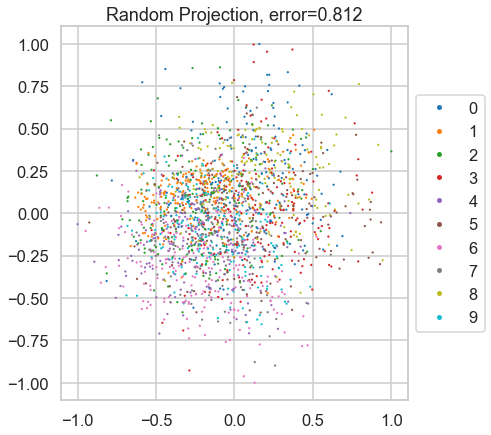

In [20]:
ax = plot_embed(X_rp, labels)
error = NN_generalization_error(X_rp, labels)
ax.set_title('Random Projection, error=%.3f' % error);

### Perform PCA on the data

(2000, 200)
Explained variance ratio by PCs: [0.09807298 0.07152192 0.0603679  0.0555894  0.04873046 0.04412763
 0.03301764 0.02921017 0.027822   0.02324382 0.02104458 0.02013437
 0.01830314 0.01745049 0.01644954 0.01505537 0.01333914 0.01261508
 0.01244286 0.0109673 ]


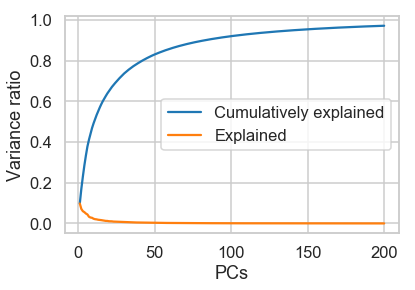

In [21]:
pca = decomposition.PCA(n_components=200)
X_pca = pca.fit_transform(X)
print (X_pca.shape)
print ('Explained variance ratio by PCs:', pca.explained_variance_ratio_[:20])
cum_var_explained = np.cumsum(pca.explained_variance_ratio_)
plt.plot(np.arange(len(cum_var_explained))+1, cum_var_explained, label='Cumulatively explained')
plt.plot(np.arange(len(cum_var_explained))+1, pca.explained_variance_ratio_, label='Explained')
plt.legend(loc='best')
plt.xlabel('PCs')
plt.ylabel('Variance ratio');

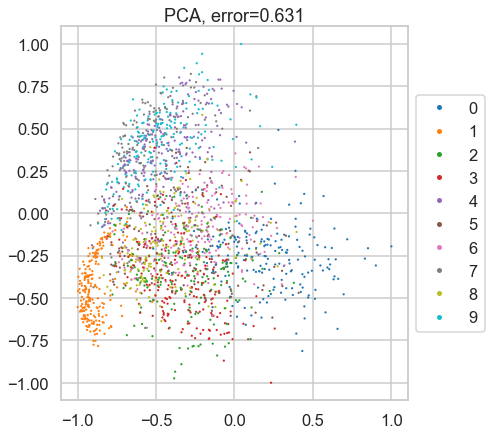

In [22]:
ax = plot_embed(X_pca, labels)
error = NN_generalization_error(X_pca, labels)
ax.set_title('PCA, error=%.3f' % error);

### Fit Variational Autoencoder to the data

In [23]:
from autoencoder_models.Autoencoder import Autoencoder
training_epochs = 20
batch_size = 128
display_step = 1
learning_rate=0.001

# AE architecture: 784 -> 500 -> 500 -> 2 -> 500 -> 500 -> 784
ae = Autoencoder([784, 500, 500, 2],            
                  optimizer=tf.train.AdamOptimizer(learning_rate)
                 )
# Training cycle
for epoch in range(training_epochs):
    avg_loss = 0.
    total_batch = int(n_samples / batch_size)
    # Loop over all batches
    for i in range(total_batch):
        batch_xs, _ = mnist.train.next_batch(batch_size)
        # Fit training using batch data
        loss = ae.partial_fit(batch_xs)
        # Compute average loss
        avg_loss += loss / n_samples * batch_size
    # Display logs per epoch step
    if epoch % display_step == 0:
        print ("Epoch %d: loss = %.4f "% (epoch+1, avg_loss))

Epoch 1: loss = 3284.9188 
Epoch 2: loss = 2864.7649 
Epoch 3: loss = 2772.4930 
Epoch 4: loss = 2682.8157 
Epoch 5: loss = 2466.0930 
Epoch 6: loss = 2264.3505 
Epoch 7: loss = 2195.8258 
Epoch 8: loss = 2138.7296 
Epoch 9: loss = 2100.2340 
Epoch 10: loss = 2068.0760 
Epoch 11: loss = 2044.6357 
Epoch 12: loss = 2020.0281 
Epoch 13: loss = 2005.5293 
Epoch 14: loss = 1991.4936 
Epoch 15: loss = 1973.7985 
Epoch 16: loss = 1960.6337 
Epoch 17: loss = 1947.2041 
Epoch 18: loss = 1935.4197 
Epoch 19: loss = 1923.3184 
Epoch 20: loss = 1915.5841 


In [24]:
X_ae = ae.transform(X)
print (X_ae.shape)

(2000, 2)


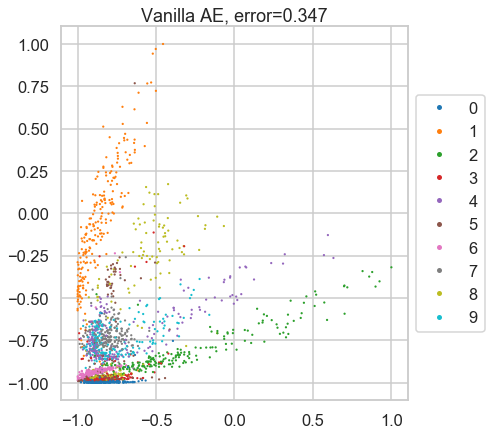

In [25]:
ax = plot_embed(X_ae, labels)
error = NN_generalization_error(X_ae, labels)
ax.set_title('Vanilla AE, error=%.3f' % error);

In [26]:
from autoencoder_models.VariationalAutoencoder import VariationalAutoencoder
training_epochs = 20
batch_size = 128
display_step = 1
learning_rate=0.001

# VAE architecture: 784 -> 500 -> 500 -> 2 -> 500 -> 500 -> 784
vae = VariationalAutoencoder([784, 500, 500, 2], 
                             optimizer=tf.train.AdamOptimizer(learning_rate)
                             )
# Training cycle
for epoch in range(training_epochs):
    avg_loss = 0.
    total_batch = int(n_samples / batch_size)
    # Loop over all batches
    for i in range(total_batch):
        batch_xs, _ = mnist.train.next_batch(batch_size)
        # Fit training using batch data
        loss = vae.partial_fit(batch_xs)
        # Compute average loss
        avg_loss += loss / n_samples * batch_size
    # Display logs per epoch step
    if epoch % display_step == 0:
        print ("Epoch %d: loss = %.4f "% (epoch+1, avg_loss))

Epoch 1: loss = 3106.7601 
Epoch 2: loss = 2486.7151 
Epoch 3: loss = 2352.9179 
Epoch 4: loss = 2261.5635 
Epoch 5: loss = 2197.4505 
Epoch 6: loss = 2143.7849 
Epoch 7: loss = 2107.9471 
Epoch 8: loss = 2073.9682 
Epoch 9: loss = 2054.3340 
Epoch 10: loss = 2027.5308 
Epoch 11: loss = 2009.1082 
Epoch 12: loss = 1993.8420 
Epoch 13: loss = 1977.0965 
Epoch 14: loss = 1967.5440 
Epoch 15: loss = 1951.3534 
Epoch 16: loss = 1940.9313 
Epoch 17: loss = 1929.1962 
Epoch 18: loss = 1915.7619 
Epoch 19: loss = 1906.7781 
Epoch 20: loss = 1902.8132 


In [27]:
X_vae = vae.transform(X)
print (X_vae.shape)

(2000, 2)


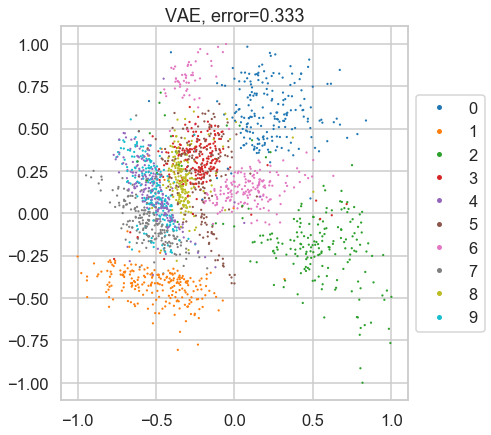

In [28]:
ax = plot_embed(X_vae, labels)
error = NN_generalization_error(X_vae, labels)
ax.set_title('VAE, error=%.3f' % error);

Next, we apply various types of DR algorithms on the PCA reduced data (50 dimensions) and compare their performances using the generalization error.

---

### Perform Spectral Embedding using different $k$ to construct kNN graph

Spectral Embedding: 
0. Compute the pairwise distance matrix
0. Construct a kNN graph based on the pairwise distance matrix
0. Perform PCA on the Laplacian matrix of the kNN graph

/Users/zichen/venv3/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


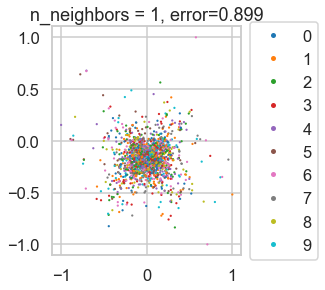

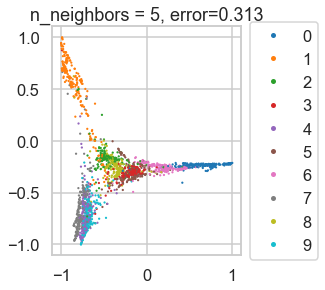

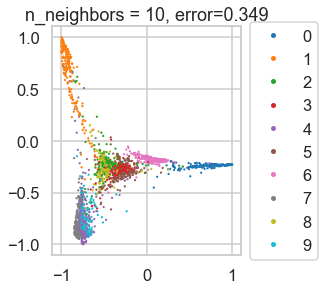

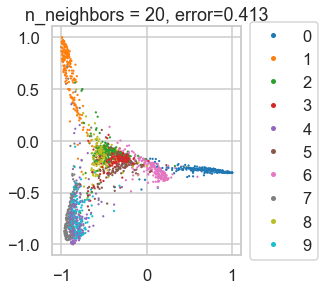

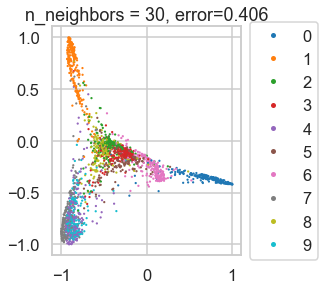

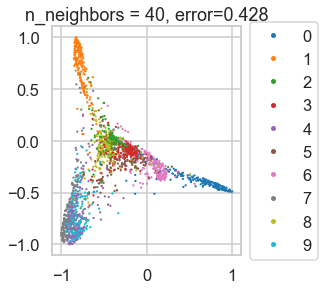

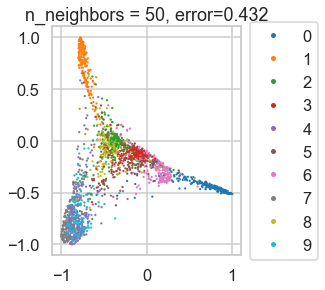

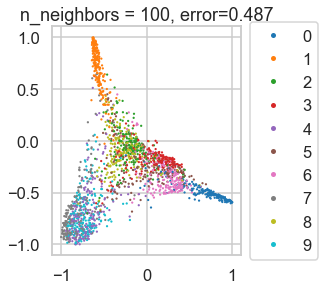

In [29]:
for n_neighbors in [1, 5, 10, 20, 30, 40, 50, 100]:
    se = manifold.SpectralEmbedding(affinity='nearest_neighbors', n_neighbors=n_neighbors)
    X_se = se.fit_transform(X_pca[:, :50])
    ax = plot_embed(X_se, labels, figsize=(4,4))
    error = NN_generalization_error(X_se, labels)
    ax.set_title('n_neighbors = %d, error=%.3f' % (n_neighbors, error))

The state-of-the-art DR algorithms:

### Perform t-SNE

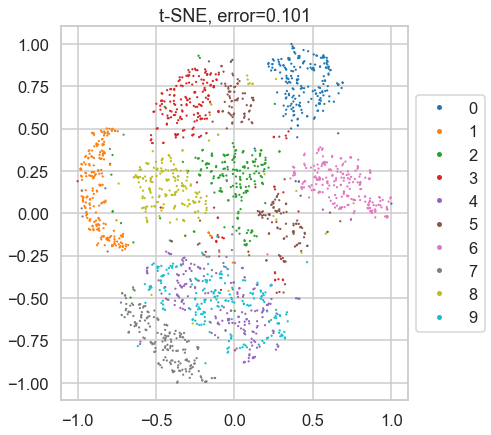

In [30]:
tsne = manifold.TSNE(metric='euclidean', random_state=2019)
X_tsne = tsne.fit_transform(X_pca[:, :50])
ax = plot_embed(X_tsne, labels)
error = NN_generalization_error(X_tsne, labels)
ax.set_title('t-SNE, error=%.3f' % error);

### Perfrom UMAP

Uniform Manifold Approximation and Projection (UMAP) is a dimensionality reduction technique that can be used for data visualisation similarly to t-SNE, but it also useful for general non-linear dimensionality reduction tasks. Implementation: https://github.com/lmcinnes/umap


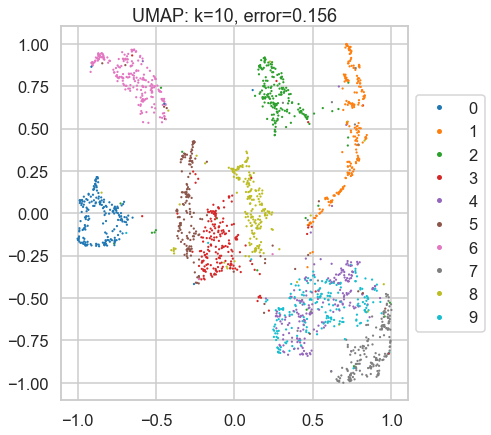

In [31]:
import umap
k = 10
umap_obj = umap.UMAP(n_neighbors=k, min_dist=0.1, metric='euclidean')
X_umap = umap_obj.fit_transform(X_pca[:, :50])
error = NN_generalization_error(X_umap, labels)
ax = plot_embed(X_umap, labels)
ax.set_title('UMAP: k=%d, error=%.3f' % (k, error));

### DR with the Fireworks Network Layout

**How to convert the pairwise distances/similarity matrix to a graph?** 

- kNN graph
- Thresholding

#### Uses kNN graph for the layout 

In [32]:
%load_ext autoreload
%autoreload 2

In [33]:
from utils import network_layout

2000 13844


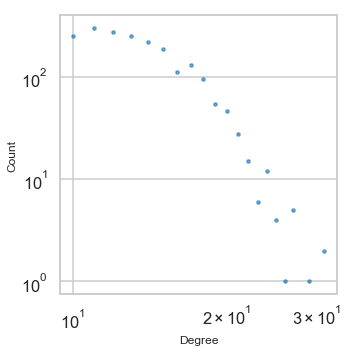

In [34]:
G = create_knn_graph(X_pca[:, :50], k=10)
print (G.number_of_nodes(), G.number_of_edges())
plot_degree_distribution(G)

In [35]:
X_knn_fd = network_layout(G, 'fr')

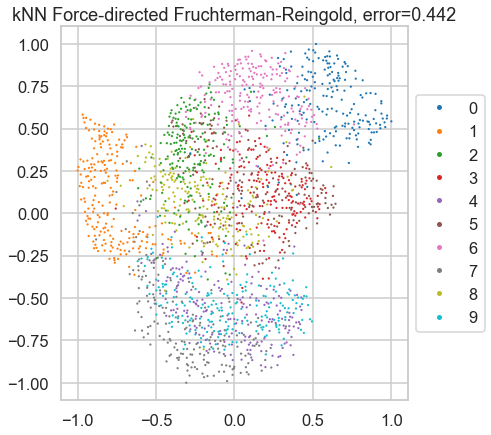

In [37]:
error = NN_generalization_error(X_knn_fd, labels)
ax = plot_embed(X_knn_fd, labels)
ax.set_title('kNN Force-directed Fruchterman-Reingold, error=%.3f' % error);

In [38]:
# Distributed Recursive (Graph) Layout
X_knn_drl = network_layout(G, 'drl')

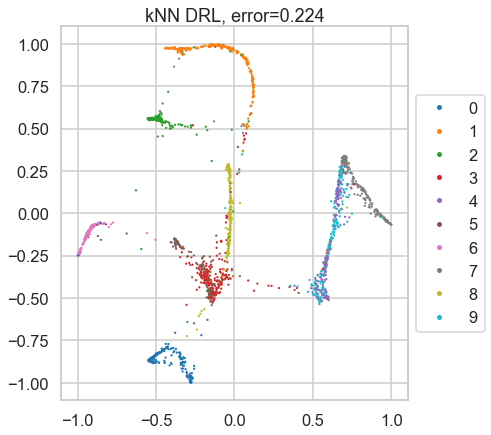

In [39]:
error = NN_generalization_error(X_knn_drl, labels)
ax = plot_embed(X_knn_drl, labels)
ax.set_title('kNN DRL, error=%.3f' % error);

In [40]:
# Kamada-Kawai layout
X_knn_kk = network_layout(G, 'kk')

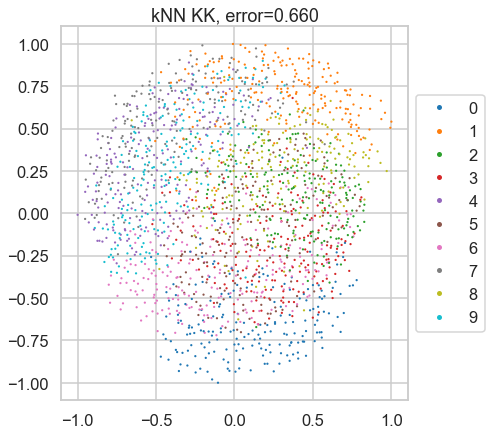

In [41]:
error = NN_generalization_error(X_knn_kk, labels)
ax = plot_embed(X_knn_kk, labels)
ax.set_title('kNN KK, error=%.3f' % error);

In [42]:
# Large Graph Layout layout
X_knn_lgl = network_layout(G, 'lgl')

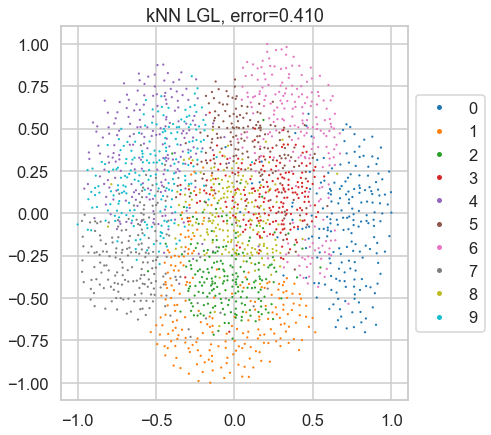

In [43]:
error = NN_generalization_error(X_knn_lgl, labels)
ax = plot_embed(X_knn_lgl, labels)
ax.set_title('kNN LGL, error=%.3f' % error);

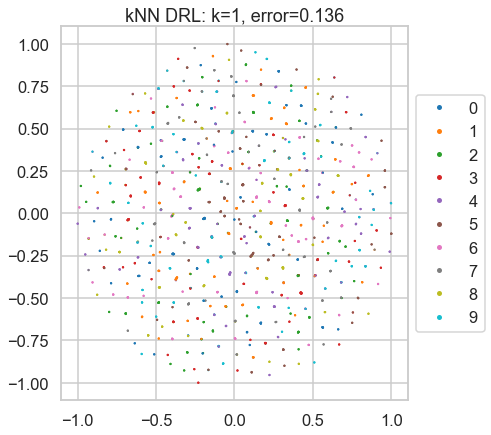

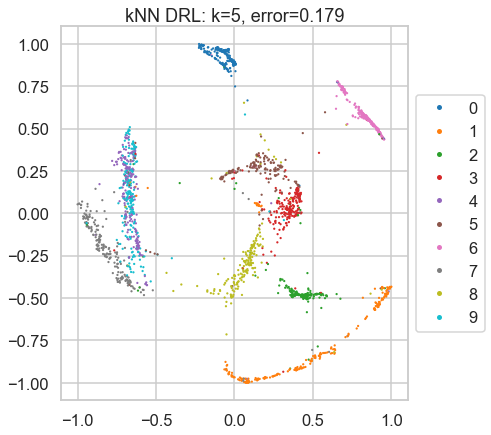

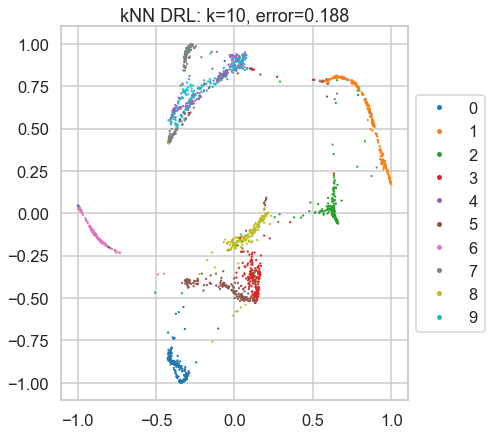

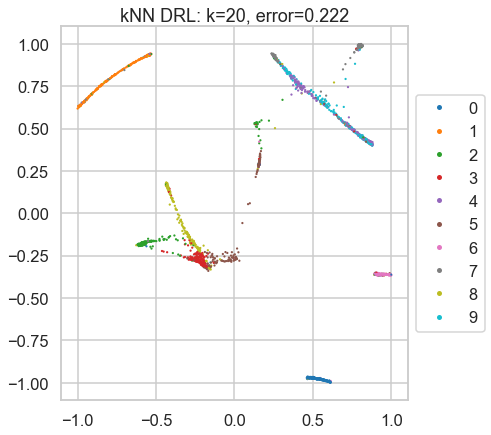

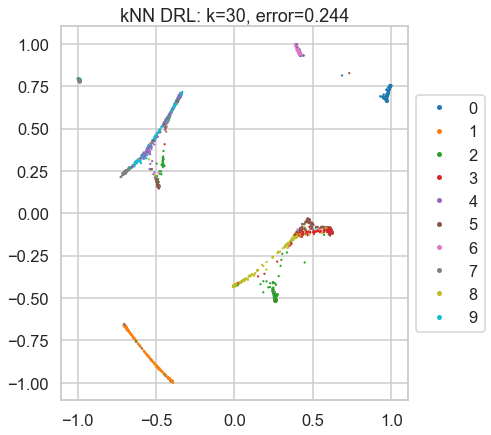

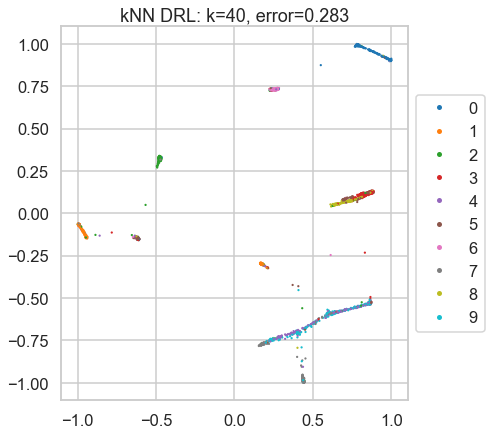

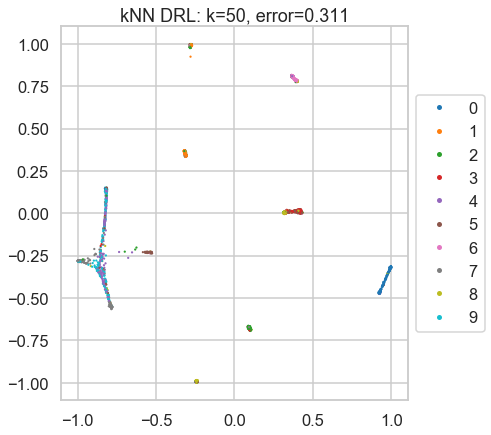

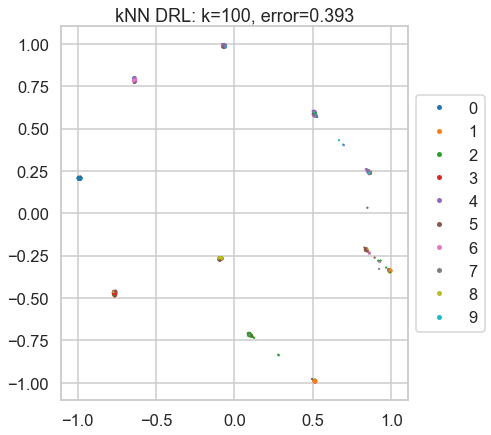

In [66]:
for k in [1, 5, 10, 20, 30, 40, 50, 100]:
    G = create_knn_graph(X_pca[:, :50], k=k)
    X_knn_fw = network_layout(G, 'drl')
    error = NN_generalization_error(X_knn_fw, labels)
    ax = plot_embed(X_knn_fw, labels)
    ax.set_title('kNN DRL: k=%d, error=%.3f' % (k, error))


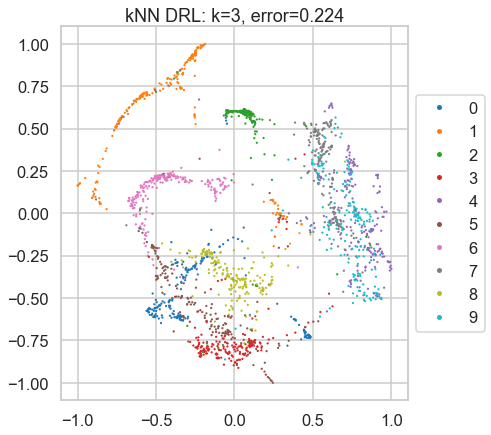

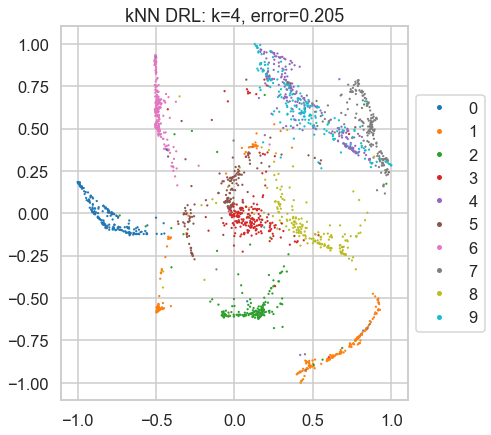

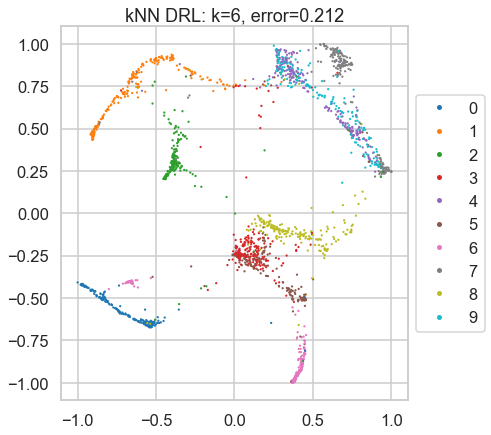

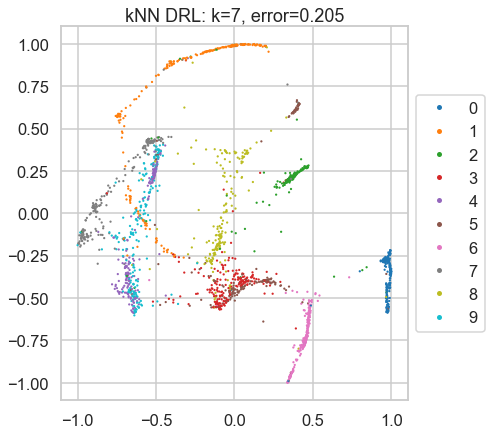

In [69]:
for k in [3, 4, 6, 7]:
    G = create_knn_graph(X_pca[:, :50], k=k)
    X_knn_drl = network_layout(G, 'drl')
    error = NN_generalization_error(X_knn_drl, labels)
    ax = plot_embed(X_knn_drl, labels)
    ax.set_title('kNN DRL: k=%d, error=%.3f' % (k, error))


#### Perform thresholding to form graphs for the Fireworks layout

In [44]:
adj_mat = compute_adjcency_mat(X_pca[:, :50], metric='euclidean')
print (adj_mat.shape)
adj_mat[:5, :5]

(2000, 2000)


array([[0.        , 0.39566833, 0.33853483, 0.35663986, 0.34445202],
       [0.39566833, 0.        , 0.34522152, 0.39413494, 0.50503075],
       [0.33853483, 0.34522152, 0.        , 0.3745054 , 0.43818057],
       [0.35663986, 0.39413494, 0.3745054 , 0.        , 0.40014082],
       [0.34445202, 0.50503075, 0.43818057, 0.40014082, 0.        ]],
      dtype=float32)

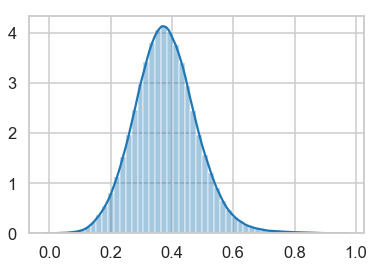

In [45]:
# Histogram for values in adj_mat
triu_idx = np.triu_indices(adj_mat.shape[0], 1)
sns.distplot(adj_mat[triu_idx])

2000 10008


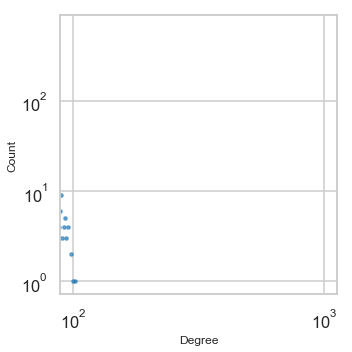

In [46]:
percentile = 99.5 
# percentile = 90
G = create_graph_by_threshold(adj_mat, percentile)
print (G.number_of_nodes(), G.number_of_edges())
plot_degree_distribution(G)

16433 2000


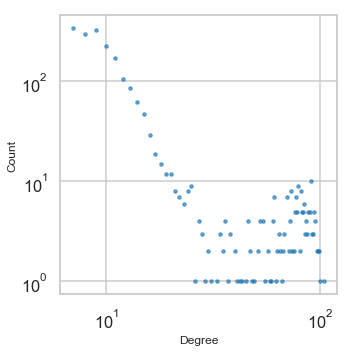

In [47]:
k = 7
G_thres_knn = create_graph_by_threshold_knn(adj_mat, percentile, k=k, X=X_pca[:, :50])
print (G_thres_knn.number_of_edges(), G_thres_knn.number_of_nodes())
plot_degree_distribution(G_thres_knn)

In [48]:
X_thre_fw = network_layout(G, 'drl')
X_threknn_fw = network_layout(G_thres_knn, 'drl')

Text(0.5,1,'threshold=99.5%, k=7, error=0.175')

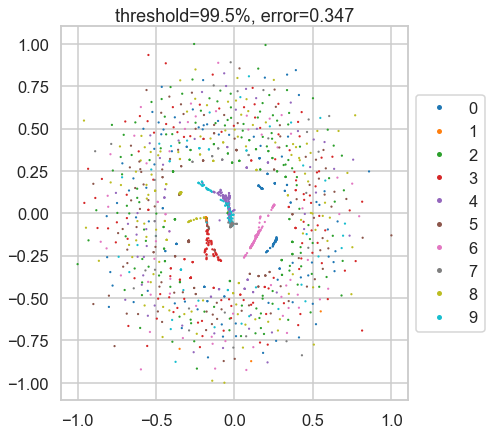

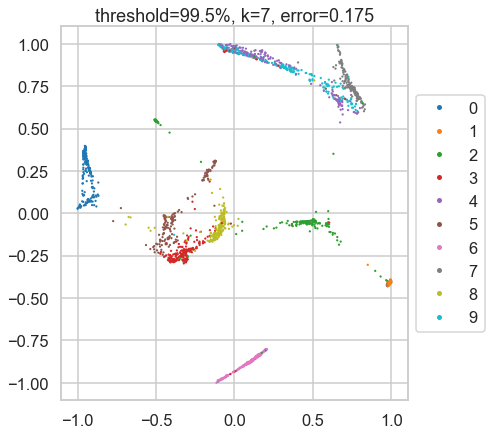

In [49]:
ax = plot_embed(X_thre_fw, labels)
error = NN_generalization_error(X_thre_fw, labels)
ax.set_title('threshold=%.1f%%, error=%.3f' %(percentile, error))

ax = plot_embed(X_threknn_fw, labels)
error = NN_generalization_error(X_threknn_fw, labels)
ax.set_title('threshold=%.1f%%, k=%d, error=%.3f' %(percentile, k, error))

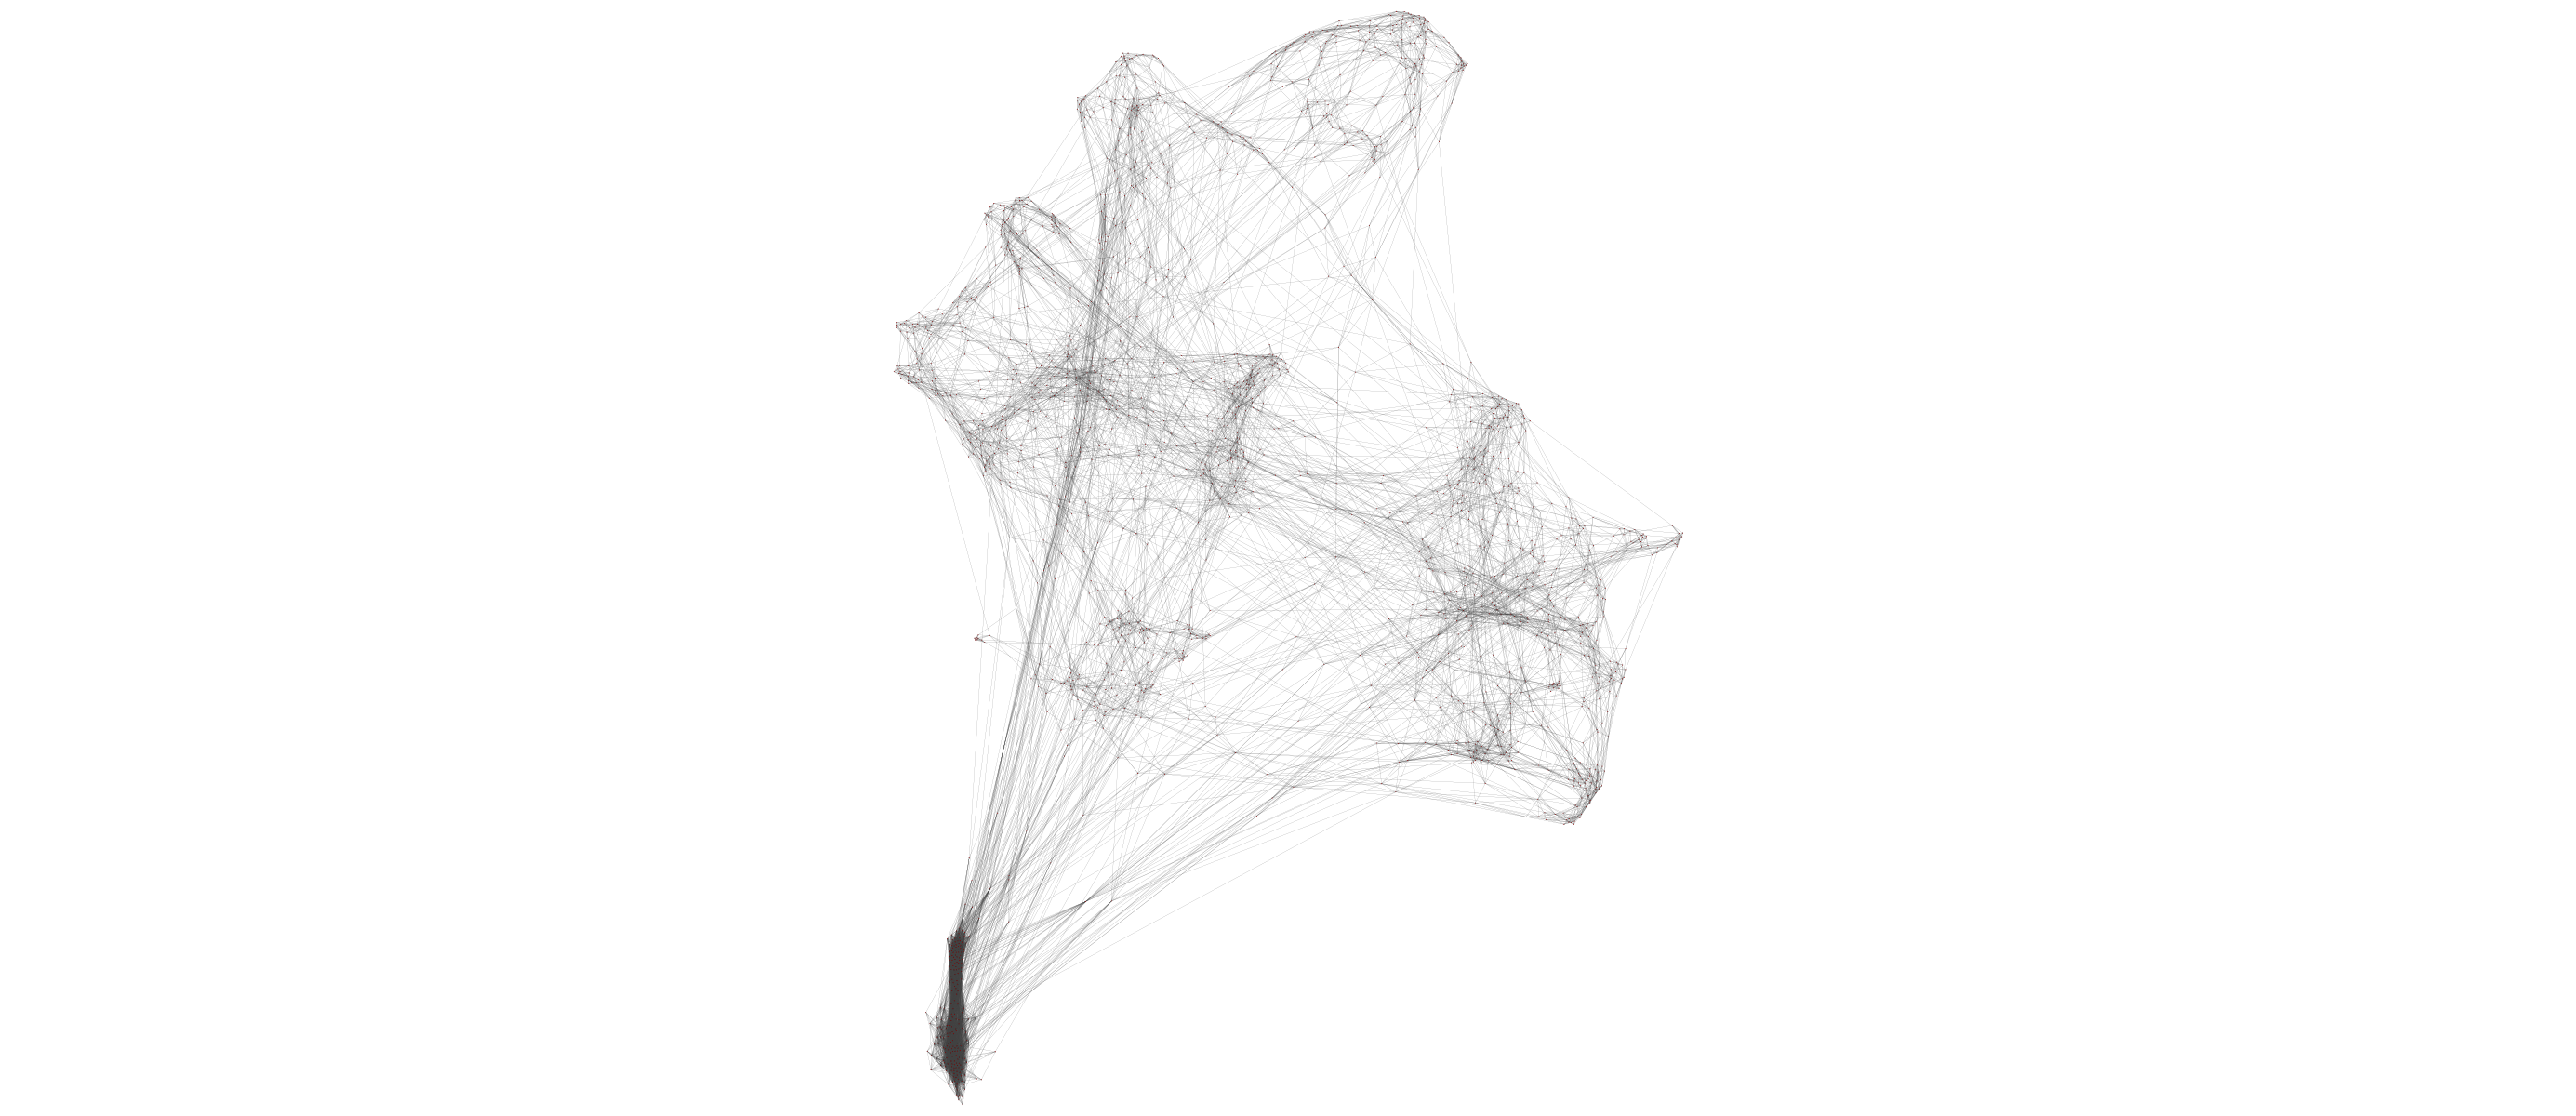

In [39]:
display.Image(G_cy.get_png())

### Problem: there are some small connected components and even isolated nodes, how to deal with them?

Current ~~solution~~: exclude

In [50]:
G_new = nx.Graph()
G_new_Gknn = nx.Graph()
for cc in nx.connected_component_subgraphs(G):
    if cc.number_of_nodes() > 10:
        G_new = nx.compose(G_new, cc)
print (G_new.number_of_nodes(), G_new.number_of_edges())

for cc in nx.connected_component_subgraphs(G_thres_knn):
    if cc.number_of_nodes() > 10:
        G_new_Gknn = nx.compose(G_new_Gknn, cc)
print (G_new_Gknn.number_of_nodes(), G_new_Gknn.number_of_edges())

1081 9829
2000 16433


To make a fair comparison between thresholding-Firework and t-SNE, re-compute the error by ignoring nodes in the small connected components.

Text(0.5,1,'threshold=99.5%, k=7, error=0.128')

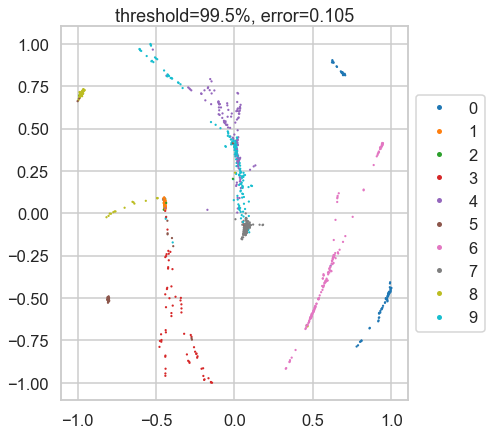

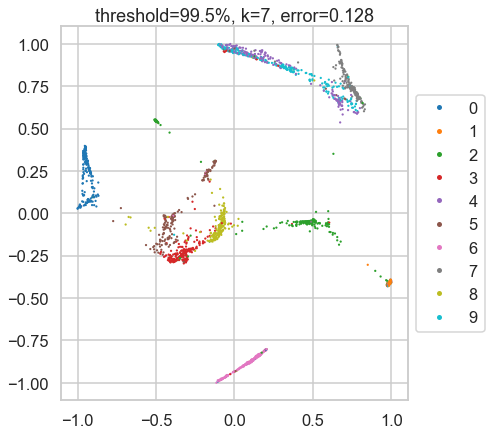

In [51]:
# Re-compute the error by ignoring the small CCs
node_idx_in_graph = G_new.nodes()
# node_idx_in_graph = G_new_Gknn.nodes()
sample_mask = np.in1d(np.arange(N), node_idx_in_graph)

ax = plot_embed(X_thre_fw[sample_mask], labels[sample_mask])
error = NN_generalization_error(X_thre_fw[sample_mask], labels[sample_mask])
ax.set_title('threshold=%.1f%%, error=%.3f' %(percentile, error))

ax = plot_embed(X_threknn_fw, labels)
error = NN_generalization_error(X_threknn_fw[sample_mask], labels[sample_mask])
ax.set_title('threshold=%.1f%%, k=%d, error=%.3f' %(percentile, k, error))

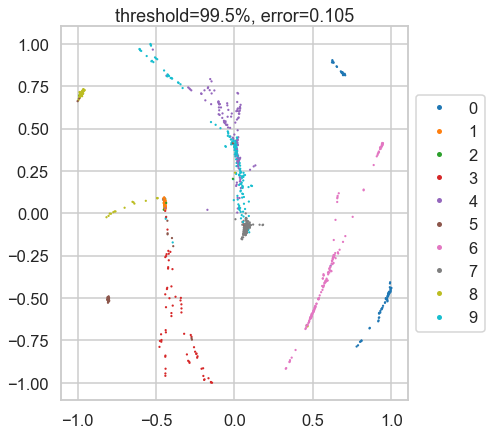

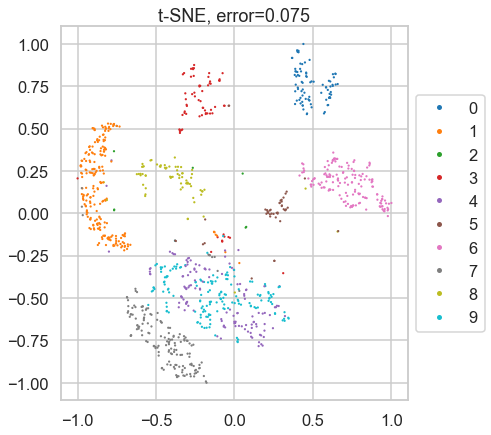

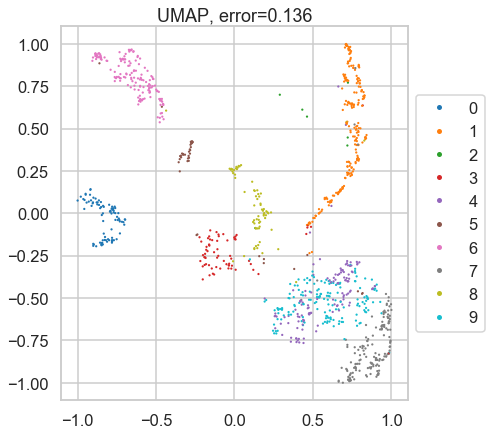

In [53]:
# Re-compute the error by ignoring the small CCs
node_idx_in_graph = G_new.nodes()
sample_mask = np.in1d(np.arange(N), node_idx_in_graph)

ax = plot_embed(X_thre_fw[sample_mask], labels[sample_mask])
error = NN_generalization_error(X_thre_fw[sample_mask], labels[sample_mask])
ax.set_title('threshold=%.1f%%, error=%.3f' %(percentile, error))

ax = plot_embed(X_tsne[sample_mask], labels[sample_mask])
error = NN_generalization_error(X_tsne[sample_mask], labels[sample_mask])
ax.set_title('t-SNE, error=%.3f' %error)

ax = plot_embed(X_umap[sample_mask], labels[sample_mask])
error = NN_generalization_error(X_umap[sample_mask], labels[sample_mask])
ax.set_title('UMAP, error=%.3f' %error);

<a id="refs"></a>

## References and further readings

+ [Making sense of principal component analysis, eigenvectors & eigenvalues](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues)
+ [Relationship between SVD and PCA](https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca)
+ [MNIST For ML Beginners](https://www.tensorflow.org/get_started/mnist/beginners)
+ [Visualizing MNIST: An Exploration of Dimensionality Reduction](http://colah.github.io/posts/2014-10-Visualizing-MNIST/)
+ [Tensorflow Embedding Projector](http://projector.tensorflow.org/)
+ [van der Maaten's t-SNE page](http://lvdmaaten.github.io/tsne/)
+ [van der Maaten et al.: Dimensionality Reduction: A Comparative Review](https://www.tilburguniversity.edu/upload/59afb3b8-21a5-4c78-8eb3-6510597382db_TR2009005.pdf)
+ [van der Maaten: Learning a Parametric Embedding by Preserving Local Structure](http://lvdmaaten.github.io/publications/papers/AISTATS_2009.pdf)
+ [Kokiopoulou and Saad: Enhanced graph-based dimensionality reduction with repulsion Laplaceans](http://www.sciencedirect.com/science/article/pii/S0031320309001460)
+ [UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction](https://arxiv.org/abs/1802.03426)
+ [Johnson Lindenstrauss lemma](https://en.wikipedia.org/wiki/Johnson%E2%80%93Lindenstrauss_lemma)
+ [Variational Autoencoder](https://jmetzen.github.io/2015-11-27/vae.html)